<a href="https://colab.research.google.com/github/hoangnam-nguyen/fcc_predict_health_costs_with_regression/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [480]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [481]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-08-29 08:53:58--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.25’

insurance.csv.25    100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2021-08-29 08:53:58 (4.44 MB/s) - ‘insurance.csv.25’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


# Clean data

Summarize the dataset

In [482]:
dataset.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


Check for null values and drop NA (if there is)

In [483]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [484]:
df = dataset.copy()
df = df.dropna()

Convert categorical to numeric variables

In [485]:
df['smoker'] = df['smoker'].astype('category').cat.codes
df['sex'] = df['sex'].astype('category').cat.codes
df = pd.get_dummies(df, columns=['region'])
df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,0,0,0,1
1,18,1,33.8,1,0,1725.55,0,0,1,0
2,28,1,33.0,3,0,4449.46,0,0,1,0
3,33,1,22.7,0,0,21984.47,0,1,0,0
4,32,1,28.9,0,0,3866.86,0,1,0,0


#Inspect and prepare data for training

Split data into train and test

In [486]:
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

Inspect the data

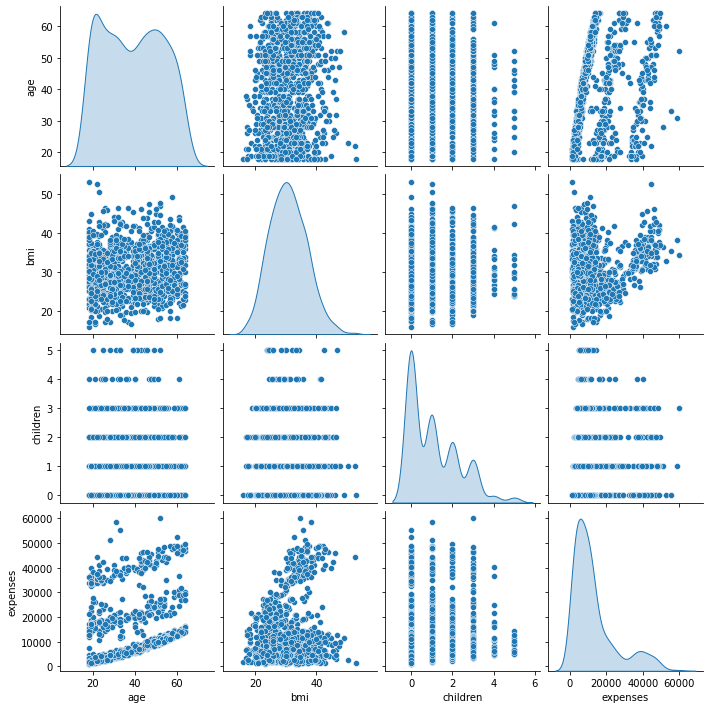

In [487]:
import seaborn as sns

sns.pairplot(dataset.sample(frac=0.8, random_state=0), diag_kind='kde')

In [488]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.00,26.000,39.000,51.0000,64.0
sex,1070.0,0.498131,0.500230,0.00,0.000,0.000,1.0000,1.0
bmi,1070.0,30.737290,6.065193,16.00,26.300,30.500,34.8000,53.1
children,1070.0,1.093458,1.211364,0.00,0.000,1.000,2.0000,5.0
smoker,1070.0,0.199065,0.399484,0.00,0.000,0.000,0.0000,1.0
expenses,1070.0,13056.551654,11994.260172,1121.87,4565.995,9289.085,15826.1125,60021.4
region_northeast,1070.0,0.248598,0.432402,0.00,0.000,0.000,0.0000,1.0
region_northwest,1070.0,0.235514,0.424518,0.00,0.000,0.000,0.0000,1.0
region_southeast,1070.0,0.281308,0.449848,0.00,0.000,0.000,1.0000,1.0
region_southwest,1070.0,0.234579,0.423934,0.00,0.000,0.000,0.0000,1.0


Split features from labels

In [489]:
train_dataset = df_train.copy()
test_dataset = df_test.copy()

train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

#Build the model

Create the model

In [490]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
  layers.Input(shape=(len(train_dataset.keys()),)),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 9)                 36        
_________________________________________________________________
dense_55 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 741
Trainable params: 723
Non-trainable params: 18
_________________________________________________________________


Compile the model

In [491]:
model.compile(
    optimizer=tf.optimizers.RMSprop(learning_rate=0.1),
    loss='mean_absolute_error',
    metrics=['mae', 'mse']
)

Train the model

In [492]:
%%time
history = model.fit(
    train_dataset,
    train_labels,
    epochs=40,
    verbose=0,
    validation_split=0.2    # Calculate validation results on 20% of the training data
)

CPU times: user 3.66 s, sys: 231 ms, total: 3.89 s
Wall time: 3.51 s


Visualize Mean Absolute Value of training and valuation

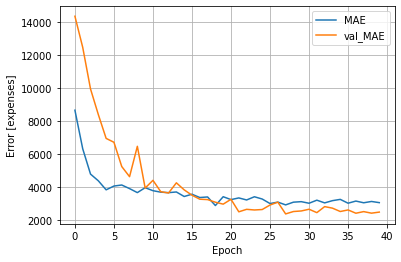

In [493]:
def plot_loss(history):
  plt.plot(history.history['mae'], label='MAE')
  plt.plot(history.history['val_mae'], label='val_MAE')
  plt.xlabel('Epoch')
  plt.ylabel('Error [expenses]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

#Pass freeCodeCamp's test

9/9 - 0s - loss: 3020.1497 - mae: 3020.1497 - mse: 37318228.0000
Testing set Mean Abs Error: 3020.15 expenses
You passed the challenge. Great job!


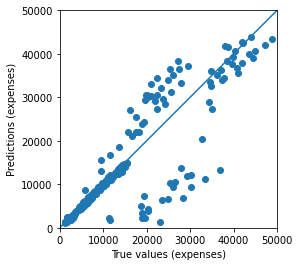

In [494]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
